# Analysis of participant's drive 

In [1]:
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client

/Users/johnmadrid/dev/phd_main/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52248 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52248/status,
Dashboard: http://127.0.0.1:52248/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52249,Workers: 4
Dashboard: http://127.0.0.1:52248/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:52260,Total threads: 4
Dashboard: http://127.0.0.1:52263/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:52252,


## 1. Load data

In [8]:
processed_folder_path = "/Users/johnmadrid/GitHub/WestdriveLoopARData/Data/1_Preprocessed/Eyetracking/0a68f111e4f448d3b8279db69cd9df5e.csv"
# Load raw unit vectors data
df = pd.read_csv(processed_folder_path)
df

,uid,UnixTimeStamp,dataset,city_section,TobiiTimeStamp,FPS,HmdPosition_x,HmdPosition_y,HmdPosition_z,NoseVector_x,...,HitPointOnObject_z_3,distanceToPlayer_3,ObjectName_4,HitObjectPosition_x_4,HitObjectPosition_y_4,HitObjectPosition_z_4,HitPointOnObject_x_4,HitPointOnObject_y_4,HitPointOnObject_z_4,distanceToPlayer_4
0,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.495712,89.967888,-0.307228,1.022527,-103.842102,0.445395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.517975,89.919945,-0.307410,1.022367,-103.841972,0.443813,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.540146,89.968414,-0.308085,1.021776,-103.842018,0.439297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.562454,89.890388,-0.309161,1.020753,-103.841881,0.430322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.584579,89.982567,-0.310638,1.019290,-103.841515,0.416664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37187,0a68f111e4f448d3b8279db69cd9df5e,1.602675e+09,EyeTracking,Autobahn,875.579163,84.273964,-604.667480,64.104576,5073.650391,0.960676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37188,0a68f111e4f448d3b8279db69cd9df5e,1.602675e+09,EyeTracking,Autobahn,875.601379,85.342766,-604.410767,64.113228,5073.747070,0.961294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37189,0a68f111e4f448d3b8279db69cd9df5e,1.602675e+09,EyeTracking,Autobahn,875.624939,85.193512,-604.153320,64.121864,5073.845215,0.961644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37190,0a68f111e4f448d3b8279db69cd9df5e,1.602675e+09,EyeTracking,Autobahn,875.636169,85.541122,-603.894714,64.130600,5073.943848,0.961842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
(df['UnixTimeStamp'].iloc[-1:] - df['UnixTimeStamp'].iloc[0]) / 60

37191    12.0359
Name: UnixTimeStamp, dtype: float64

In [16]:
(df['TobiiTimeStamp'].iloc[-1:] - df['TobiiTimeStamp'].iloc[0]) / 60

37191    12.036052
Name: TobiiTimeStamp, dtype: float64

In [23]:
# convert time to seconds from reference time
def time_convert_2(df):
    """This function is taking a DataFrame, with a Unix timestamp column, converting it to datetime objects, using it as the index, creating a new column with time duration and returning the modified DataFrame.
    """
    df['timestamp_REF'] = pd.to_datetime(df.UnixTimeStamp,
                                         utc=True,
                                         unit='s',
                                         origin='unix')

    df.set_index('timestamp_REF', inplace=True)
    df['Time_duration'] = (df.groupby(
        ['uid']).transform(lambda x: (x.index - x.index[
            0]) / np.timedelta64(1, 's')).TobiiTimeStamp)
    df = df.reset_index(drop=False)
    return df

In [24]:
df_time = df.pipe(time_convert_2)
df_time

,timestamp_REF,uid,UnixTimeStamp,dataset,city_section,TobiiTimeStamp,FPS,HmdPosition_x,HmdPosition_y,HmdPosition_z,...,distanceToPlayer_3,ObjectName_4,HitObjectPosition_x_4,HitObjectPosition_y_4,HitObjectPosition_z_4,HitPointOnObject_x_4,HitPointOnObject_y_4,HitPointOnObject_z_4,distanceToPlayer_4,Time_duration
0,2020-10-14 11:09:49.893796608+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.495712,89.967888,-0.307228,1.022527,-103.842102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,2020-10-14 11:09:49.906761728+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.517975,89.919945,-0.307410,1.022367,-103.841972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012965
2,2020-10-14 11:09:49.929700608+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.540146,89.968414,-0.308085,1.021776,-103.842018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035904
3,2020-10-14 11:09:49.951642624+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.562454,89.890388,-0.309161,1.020753,-103.841881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057846
4,2020-10-14 11:09:49.973583616+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602674e+09,EyeTracking,TrainingScene,153.584579,89.982567,-0.310638,1.019290,-103.841515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.079787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37187,2020-10-14 11:21:51.968003328+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602675e+09,EyeTracking,Autobahn,875.579163,84.273964,-604.667480,64.104576,5073.650391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,722.074207
37188,2020-10-14 11:21:51.990941696+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602675e+09,EyeTracking,Autobahn,875.601379,85.342766,-604.410767,64.113228,5073.747070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,722.097145
37189,2020-10-14 11:21:52.014877696+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602675e+09,EyeTracking,Autobahn,875.624939,85.193512,-604.153320,64.121864,5073.845215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,722.121081
37190,2020-10-14 11:21:52.024850944+00:00,0a68f111e4f448d3b8279db69cd9df5e,1.602675e+09,EyeTracking,Autobahn,875.636169,85.541122,-603.894714,64.130600,5073.943848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,722.131054


In [25]:
df_time['Time_duration'].describe()

count    37192.000000
mean       384.270604
std        205.033196
min          0.000000
25%        222.187421
50%        391.515790
75%        559.543207
max        722.153993
Name: Time_duration, dtype: float64

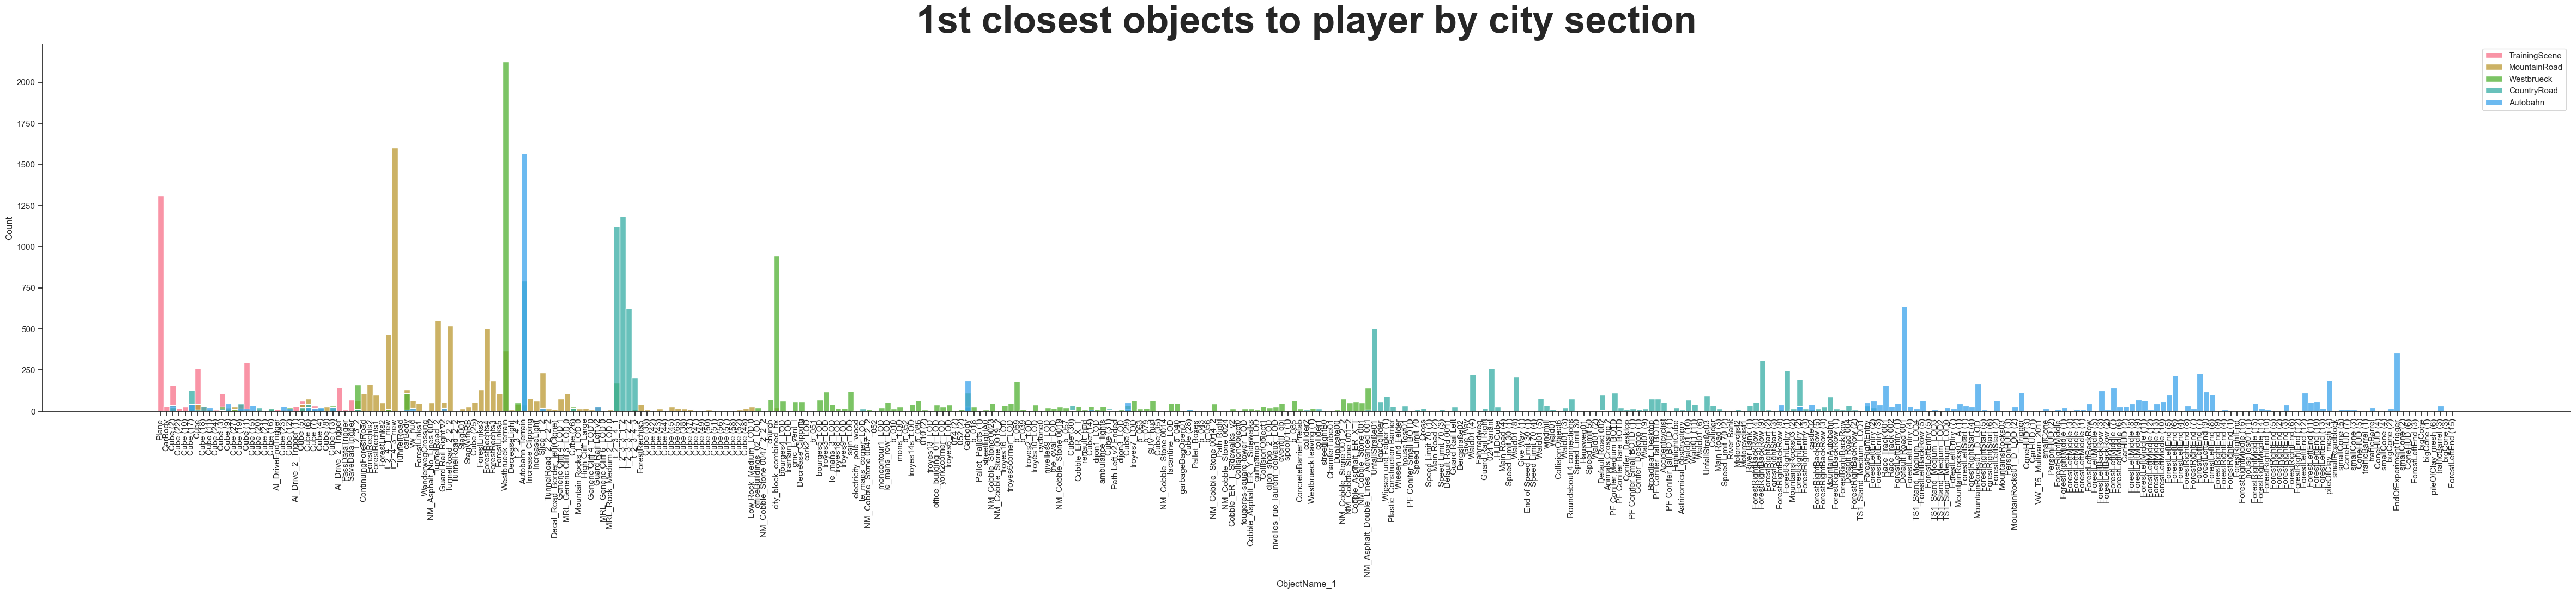

In [226]:
g = sns.FacetGrid(df_time, col='dataset',hue='city_section', height=11, aspect= 4.3)
g.map(sns.histplot,'ObjectName_1')
g.tick_params(axis='x', rotation=90)
plt.title('1st closest objects to player by city section', fontsize=50, y=1.02, fontweight='bold')
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/' + '1st_closes_objects_'+f'{str(df_time["uid"].unique())}'+'.png', dpi=300)
plt.savefig('Plots/' + '1st_closest_objects_'+f'{df_time["uid"][0]}'+'.pdf', dpi=1200, bbox_inches='tight')

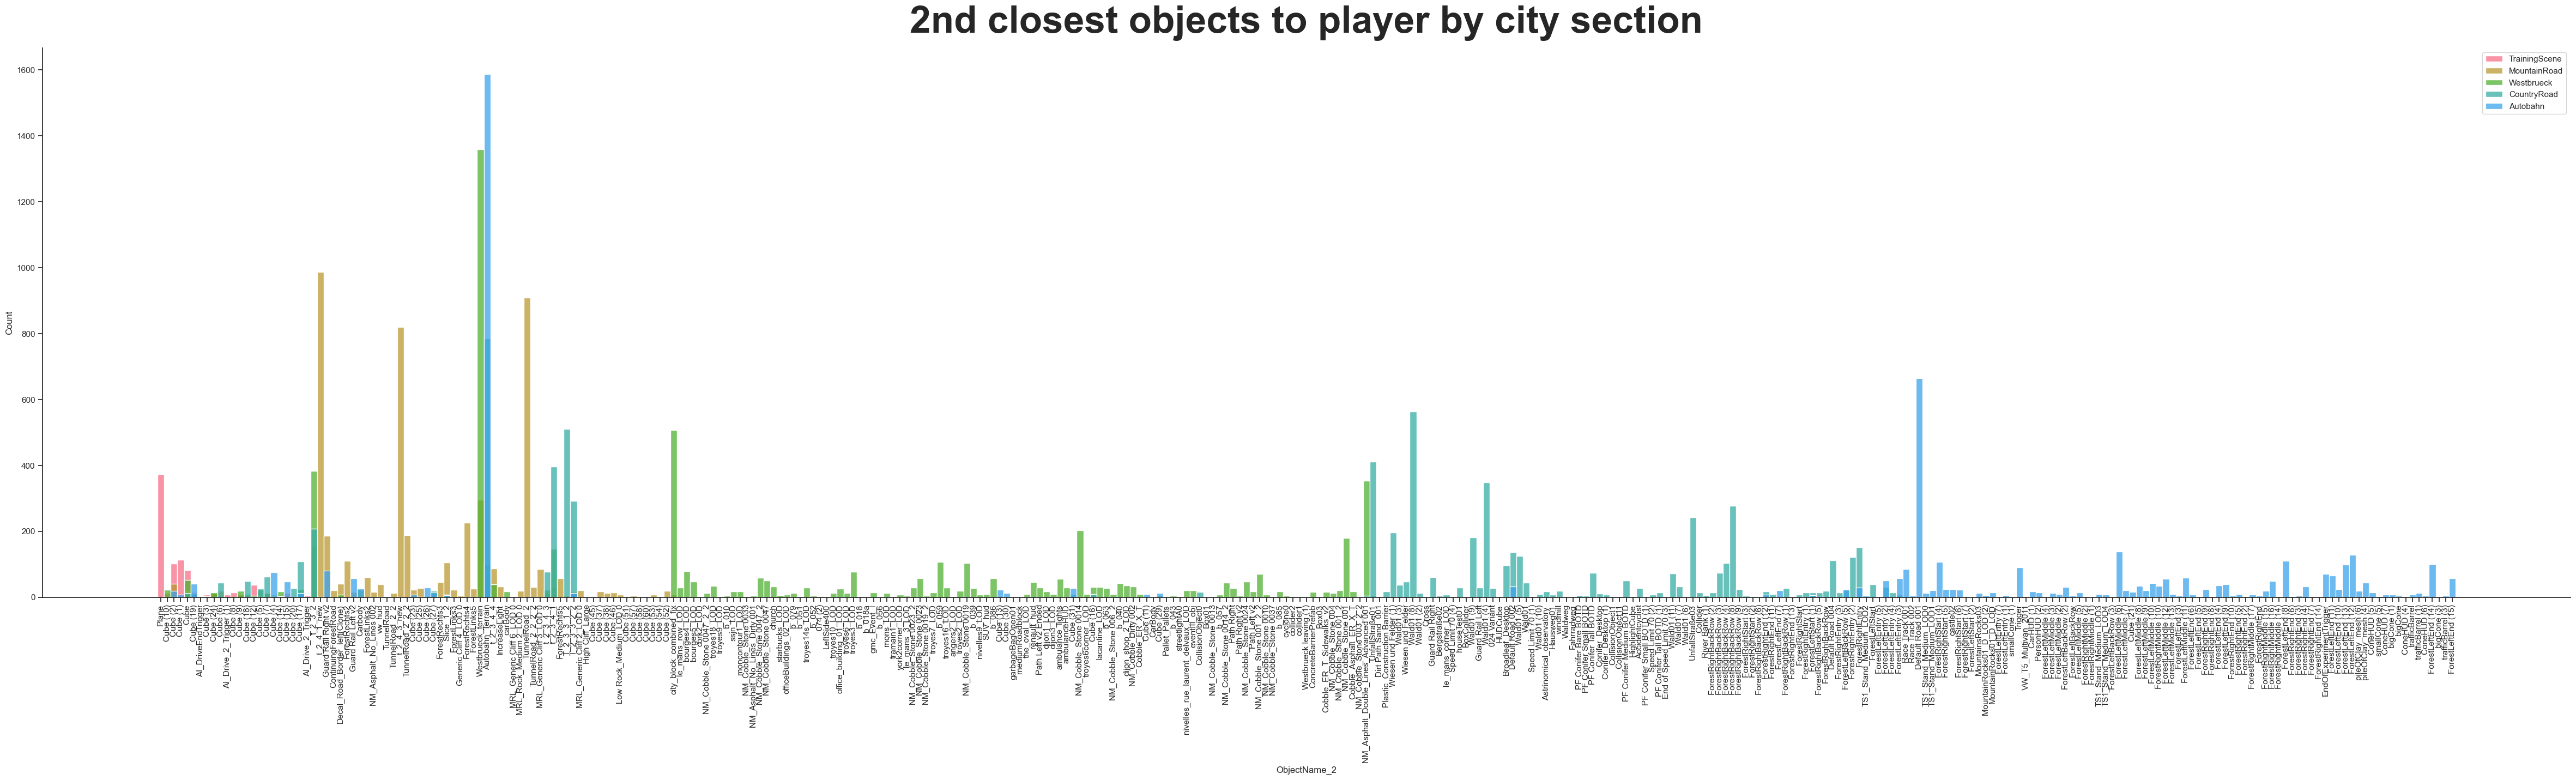

In [227]:
g = sns.FacetGrid(df_time, col='dataset',hue='city_section',height=11, aspect= 4.3)
g.map(sns.histplot,'ObjectName_2')
g.tick_params(axis='x', rotation=90)
plt.title('2nd closest objects to player by city section', fontsize=50, y=1.02, fontweight='bold')
plt.legend()
plt.savefig('Plots/' + '2nd_closest_objects_'+f'{df_time["uid"][0]}'+'.pdf', dpi=1200, bbox_inches='tight')


In [ ]:
# fig, ax = plt.subplots(figsize =(10,12\)
g = sns.FacetGrid(df_time, col='dataset',hue='city_section', height=14, aspect= 3)
g.map(sns.histplot,'ObjectName_1',"city_section")
plt.title('1st closest objects to player by city section', fontsize=50, y=1.02, fontweight='bold')
g.tick_params(axis='x', rotation=90)
g.add_legend()
# plt.savefig('Plots/' + '2nd_closest_objects_grid'+f'{df_time["uid"][0]}'+'.pdf', dpi=1200, bbox_inches='tight')


In [149]:
# g = sns.FacetGrid(df_time, col='city_section',col_wrap=1,height=5, aspect= 4)
# g.map(sns.histplot,'ObjectName_1')
# g.tick_params(axis='x', rotation=90)

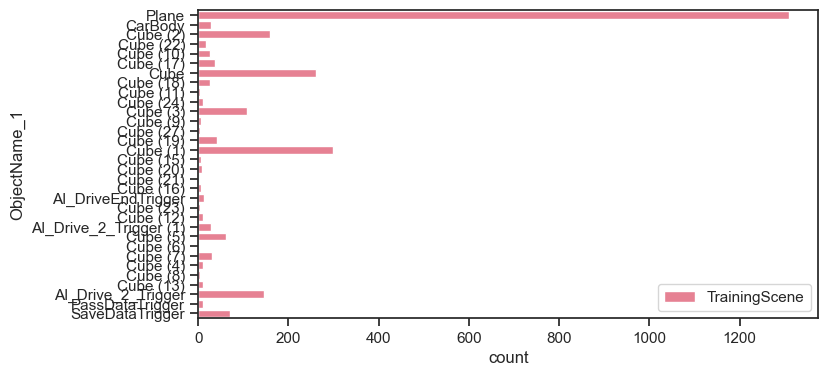

In [152]:
fig, ax = plt.subplots( figsize = (8,4))
g = sns.countplot(y="ObjectName_1", data=df_time[df_time['city_section']=="TrainingScene"],label='TrainingScene',ax=ax)
# ax.tick_params(axis='x', rotation=90)


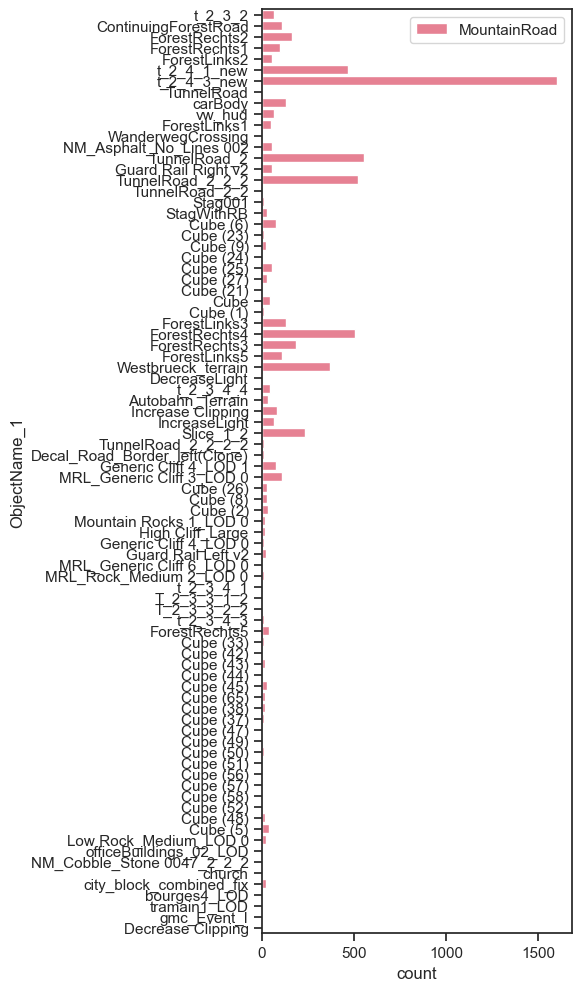

In [160]:
fig, ax = plt.subplots( figsize = (4,12))
g = sns.countplot(y="ObjectName_1", data=df_time[df_time['city_section']=="MountainRoad"],label='MountainRoad',ax=ax)
# ax.tick_params(axis='x', rotation=90)

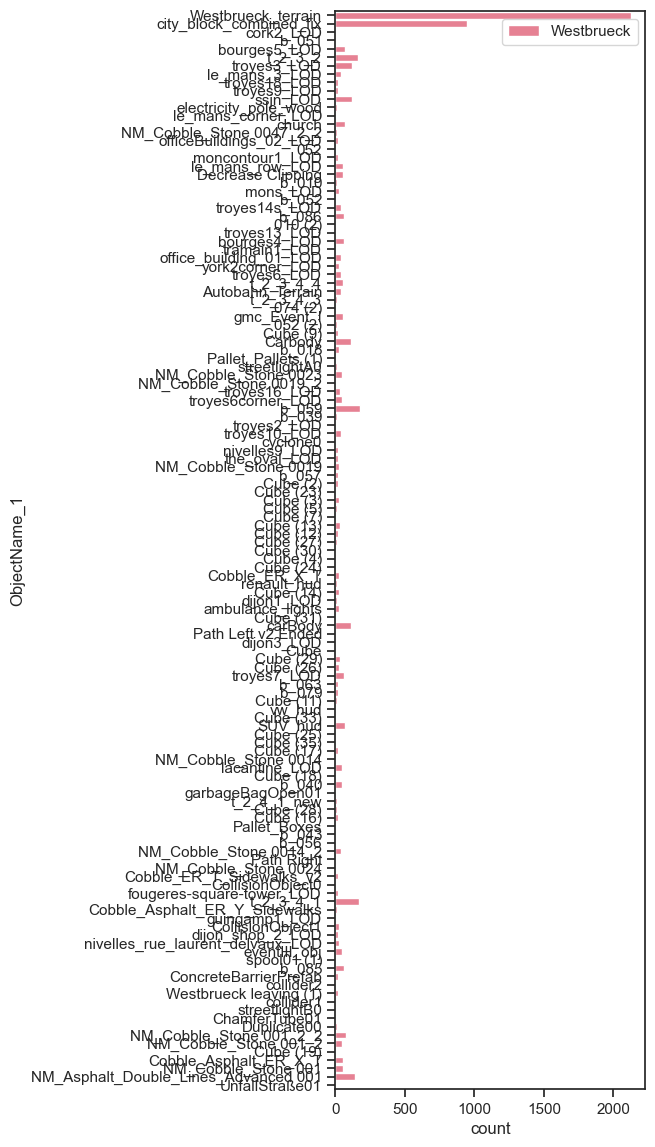

In [159]:
fig, ax = plt.subplots( figsize = (4,14))
g = sns.countplot(y="ObjectName_1", data=df_time[df_time['city_section']=="Westbrueck"],label='Westbrueck',ax=ax)
# ax.tick_params(axis='x', rotation=90)

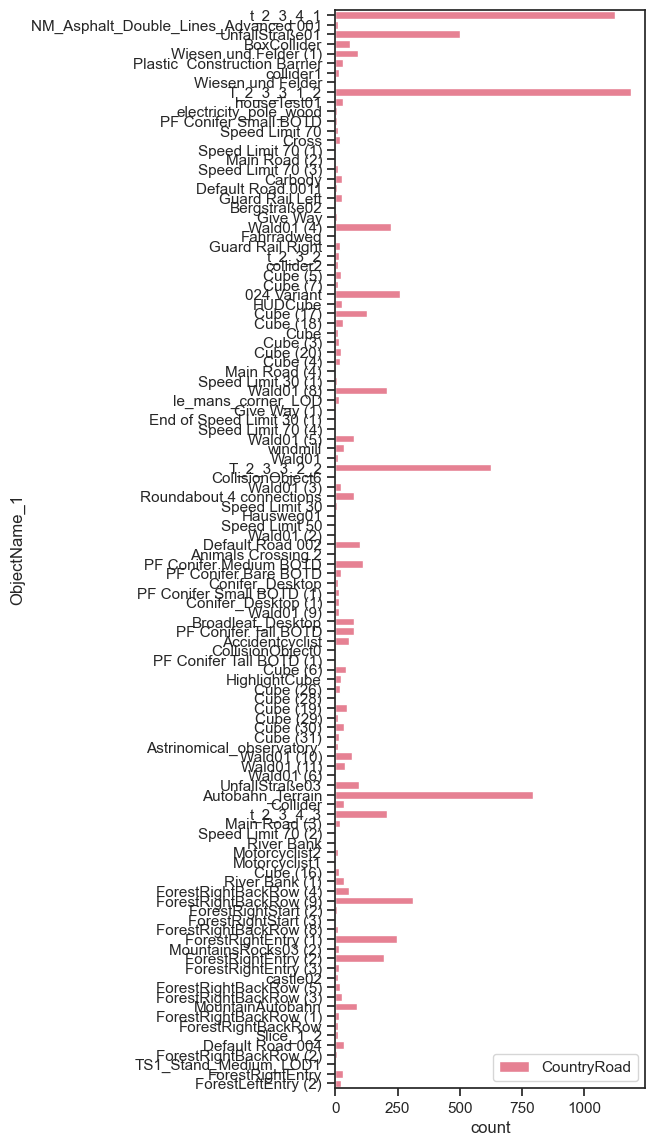

In [161]:
fig, ax = plt.subplots( figsize = (4, 14))
g = sns.countplot(y="ObjectName_1", data=df_time[df_time['city_section']=="CountryRoad"],label='CountryRoad',ax=ax)
# ax.tick_params(axis='x', rotation=90)

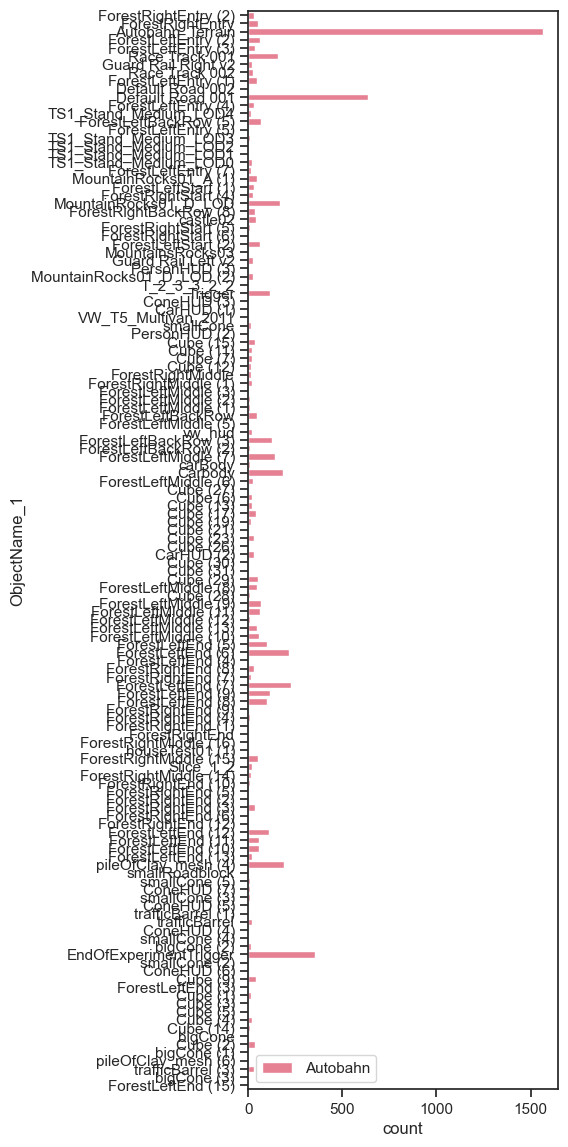

In [163]:
fig, ax = plt.subplots( figsize = (4,14))
g = sns.countplot(y="ObjectName_1", data=df_time[df_time['city_section']=="Autobahn"],label='Autobahn',ax=ax)
# ax.tick_params(axis='x', rotation=90)

In [215]:
uid = str(df_time["uid"][0])
uid

'0a68f111e4f448d3b8279db69cd9df5e'

/var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/ipykernel_5945/1571373903.py:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  plt.savefig('Plots/' + '1st_closes_objects_'+f'{df_time["uid"].unique().tostring()}'+'.pdf', dpi=1200, bbox_inches='tight')


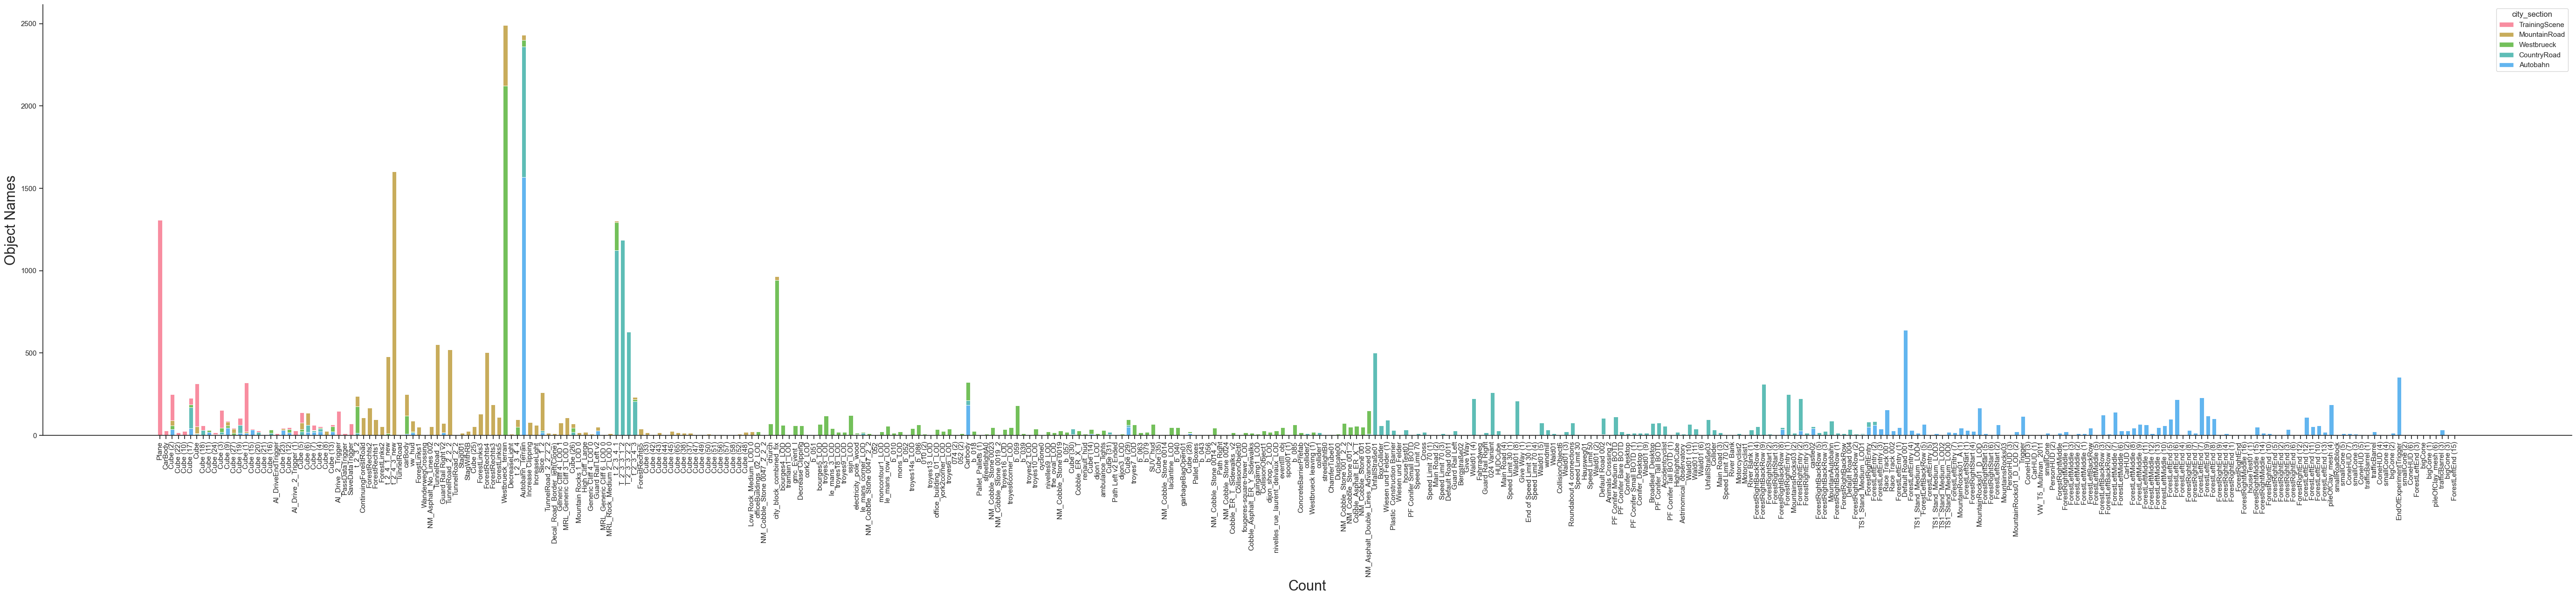

In [210]:
# count the times each unique object game ID repeats in the images dataset
fig, ax = plt.subplots(figsize=(70,12))
# plt.suptitle("Count per unique ID", fontsize=26, y=0.9, fontweight='bold')
plt.rcParams.update({'font.size': 8})
df.sort_values(['ObjectName_1'], inplace=True)
ax.set_xlabel("Count", fontsize=22)
ax.set_ylabel("Object Names", fontsize=22)
sns.despine(top=True)
sns.histplot(data=df_time, x=df_time['ObjectName_1'], hue='city_section', multiple="stack", shrink=0.7, alpha=0.8)
ax.tick_params(axis='x', rotation=90)
# plt.savefig('Plots/' + '1st_closes_objects_'+f'{str(df_time["uid"][0])}'+'.pdf', dpi=1200, bbox_inches='tight')
